# Model validation

Mapping an optimization problem to a formalism that a quantum computer can handle requires building a model. This model must be validated to ensure that its solutions correspond to the solutions of the original optimization problem we setout to solve. In this `how-to` we illustrate this mapping with the maximum independent set (MIS) problem. In MIS we seek the largest set of nodes of a graph $G=(V, E)$ such that no two nodes in the maximum independent set share an edge. Mathematically,

\begin{align}
&\max_{x\in\{0,1\}^n}\sum_{i\in V} x_i \\
&\text{s.t.}\quad x_i+x_j\leq 1\quad\forall~(i,j)\in E.
\end{align}
Here, $n=|V|$ is the number of nodes of $G$ and if the decision variable $x_i=1$ then node $i$ is in the independent set. First, we will define a MIS problem instance on a small five node graph. Such small instances are easy to solve and they allow us to test our modelling pipeline.

In [1]:
import rustworkx as rx

graph = rx.PyGraph()

# Add 5 nodes (0 through 4)
graph.add_nodes_from([None] * 5)

# Add edges
edges = [(0, 1, 1), (0, 4, 1), (1, 2, 1), (1, 4, 1), (2, 3, 1), (3, 4, 1)]
graph.add_edges_from(edges)

EdgeIndices[0, 1, 2, 3, 4, 5]

In [2]:
from qiskit_addon_opt_mapper.applications import IndependentSet

mis = IndependentSet(graph)

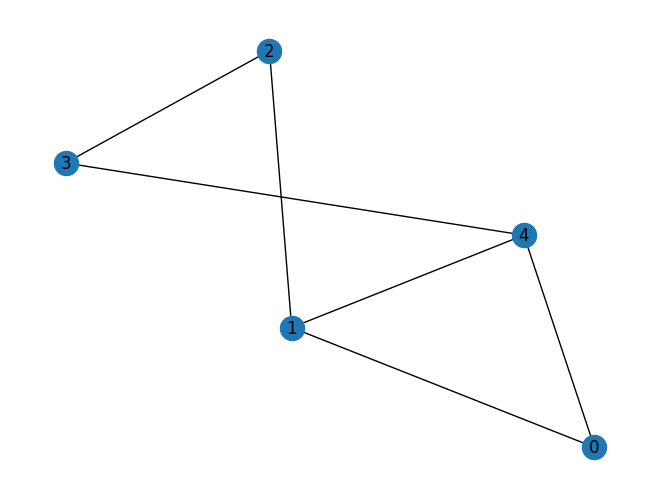

In [3]:
mis.draw()

In [4]:
opt_problem = mis.to_optimization_problem()
print(opt_problem.prettyprint())

Problem name: Independent set

Maximize
  x_0 + x_1 + x_2 + x_3 + x_4

Subject to
  Linear constraints (6)
    x_0 + x_1 <= 1  'c0'
    x_0 + x_4 <= 1  'c1'
    x_1 + x_2 <= 1  'c2'
    x_1 + x_4 <= 1  'c3'
    x_2 + x_3 <= 1  'c4'
    x_3 + x_4 <= 1  'c5'

  Binary variables (5)
    x_0 x_1 x_2 x_3 x_4



To implement this problem on a quantum computer we need to convert the problem to a quadratic unconstrained binary optimization problem. This requires mapping inequality constraints into equality constraints and then add them as penalty terms to the objective. We do this with the `LinearInequalityToPenalty` converter.

In [5]:
from qiskit_addon_opt_mapper.converters import LinearInequalityToPenalty

penalty = 0.5
converter = LinearInequalityToPenalty(penalty=penalty)
converted_prob = converter.convert(opt_problem)

The result of the conversion is the optimization problem shown below. This problem no longer has any constraints. The objective is then easily converted into an Ising Hamiltonian, a step that we will not show here. Instead, we ask the question: *"Is the unconstrained model of the MIS problem a good one?"* Indeed, we made the choice to set `penalty = 0.5`, but was this a good choice?

In [6]:
print(converted_prob.prettyprint())

Problem name: Independent set

Maximize
  -0.5*x_0*x_1 - 0.5*x_0*x_4 - 0.5*x_1*x_2 - 0.5*x_1*x_4 - 0.5*x_2*x_3
  - 0.5*x_3*x_4 + x_0 + x_1 + x_2 + x_3 + x_4

Subject to
  No constraints

  Binary variables (5)
    x_0 x_1 x_2 x_3 x_4



To answer the question above we need to solve our model and see if the solution is indeed an independent set. We do this with a classical solver. Here, we use CPLEX which at this small scale runs very efficiently. The code below, imports the solver, solves the model and interprets the result as a candidate solution to our original MIS optimization problem.

In [7]:
from qiskit_addon_opt_mapper.solvers import CplexSolver

validation_solver = CplexSolver()

result = validation_solver.solve(converted_prob)
y = converter.interpret(result.x)

In [8]:
print("Objective value", opt_problem.objective.evaluate(y))
print("Is y feasible?", opt_problem.is_feasible(y))

Objective value 4.0
Is y feasible? False


The result above indicates that the solution to our model is an infeasible solution to the MIS problem! This is problematic and indicates that something went wrong in the problem modeling. Indeed, the conversion of the constraints into penalty terms is not strong enough to enforce the independent set conditions. To remdy this situation we change the modelling and increase the value of the penalty.

In [9]:
penalty2 = 2
converter2 = LinearInequalityToPenalty(penalty=penalty2)
converted_prob2 = converter2.convert(opt_problem)

In [10]:
print(converted_prob2.prettyprint())

Problem name: Independent set

Maximize
  -2*x_0*x_1 - 2*x_0*x_4 - 2*x_1*x_2 - 2*x_1*x_4 - 2*x_2*x_3 - 2*x_3*x_4 + x_0
  + x_1 + x_2 + x_3 + x_4

Subject to
  No constraints

  Binary variables (5)
    x_0 x_1 x_2 x_3 x_4



Now, we solve this new model with CPLEX.

In [11]:
result2 = validation_solver.solve(converted_prob2)
y2 = converter.interpret(result2.x)

In [12]:
print("Objective value", opt_problem.objective.evaluate(y2))
print("Is y feasible?", opt_problem.is_feasible(y2))

Objective value 2.0
Is y feasible? True


We observe that the optimal solution found by CPLEX is feasible. We can also visualize the solution form the bad model and the one from the good model. As seen below, there are multiple nodes in the bad solution `y` which share an edge and are therefore not an independent set. This tutorial shows how modelling assumptions play an important role in the type of solution obtained. It also shows how important it is to test the modelling pipeline with small problem instances that can be efficiently solved.

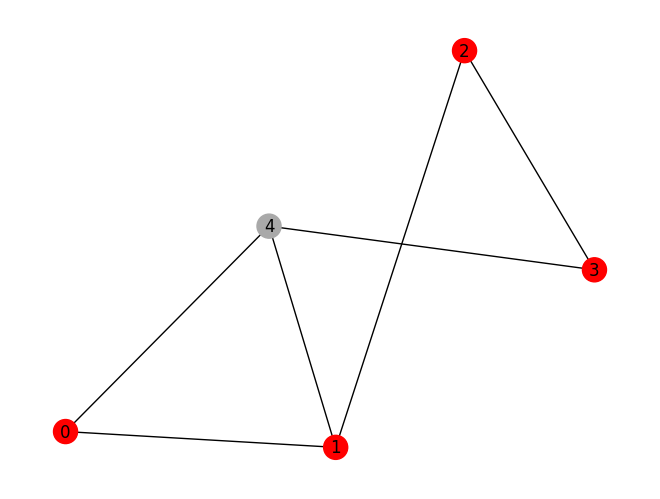

In [13]:
mis.draw(y)

In the good solution `y2`, drawn below, we see that no two nodes share an edge and are therefore an independent set.

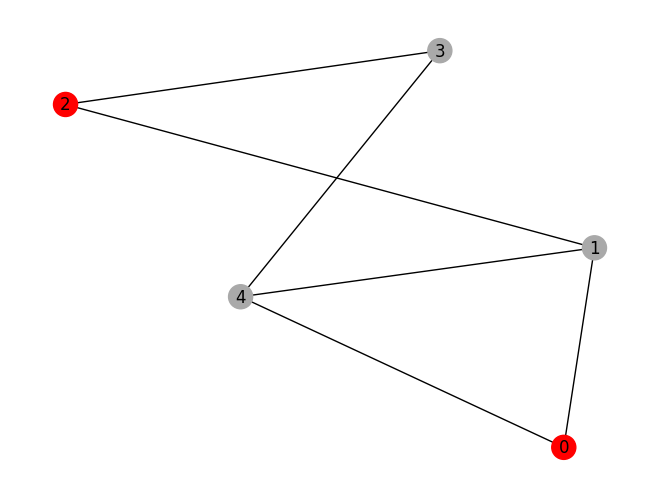

In [14]:
mis.draw(y2)